### Costa Rican Household Poverty Level Prediction

### Problem and Data Explanation

The data for this competition is provided in two files: train.csv and test.csv. The training set has 9557 rows and 143 columns while the testing set has 23856 rows and 142 columns. Each row represents one individual and each column is a feature, either unique to the individual, or for the household of the individual. The training set has one additional column, Target, which represents the poverty level on a 1-4 scale and is the label for the competition. A value of 1 is the most extreme poverty.

This is a supervised multi-class classification machine learning problem:

- Supervised: provided with the labels for the training data
- Multi-class classification: Labels are discrete values with 4 classes

### Exploratory Data Analysis (EDA)

We'll use a familiar stack of data science libraries: Pandas, numpy, matplotlib, seaborn, and eventually sklearn for modeling.

In [30]:
#data manipulation
import numpy as np 
import pandas as pd

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set a few plotting defaults
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18
plt.rcParams['patch.edgecolor'] = 'k'

### Read in Data

In [31]:
# Read in train data
train = pd.read_csv('train-costarica.csv')
test = pd.read_csv('test-costarica.csv')
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


The object columns might pose an issue because they cannot be fed directly into a machine learning model.

In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


#### Integer Type

For each column, we'll count the number of unique values and show the result in a bar plot.

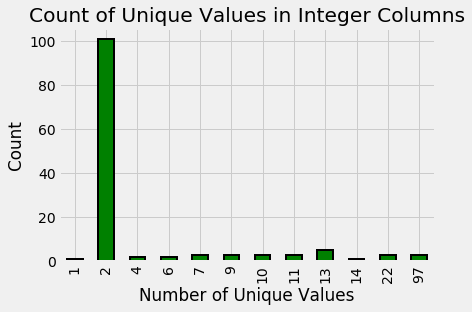

In [40]:
train.select_dtypes(np.int64).nunique().value_counts().sort_index().plot.bar(color='green', figsize=(6,4), 
                                                                           edgecolor = 'k', linewidth = 2);
plt.xlabel('Number of Unique Values'); plt.ylabel('Count');
plt.title('Count of Unique Values in Integer Columns');

The columns with only 2 unique values represent Booleans (0 or 1).

#### Float Data Types

Type float  represent continuous variables. We can make a quick distribution plot to show the distribution of all float columns. We'll use an OrderedDict to map the poverty levels to colors because this keeps the keys and values in the same order as we specify (unlike a regular Python dictionary).

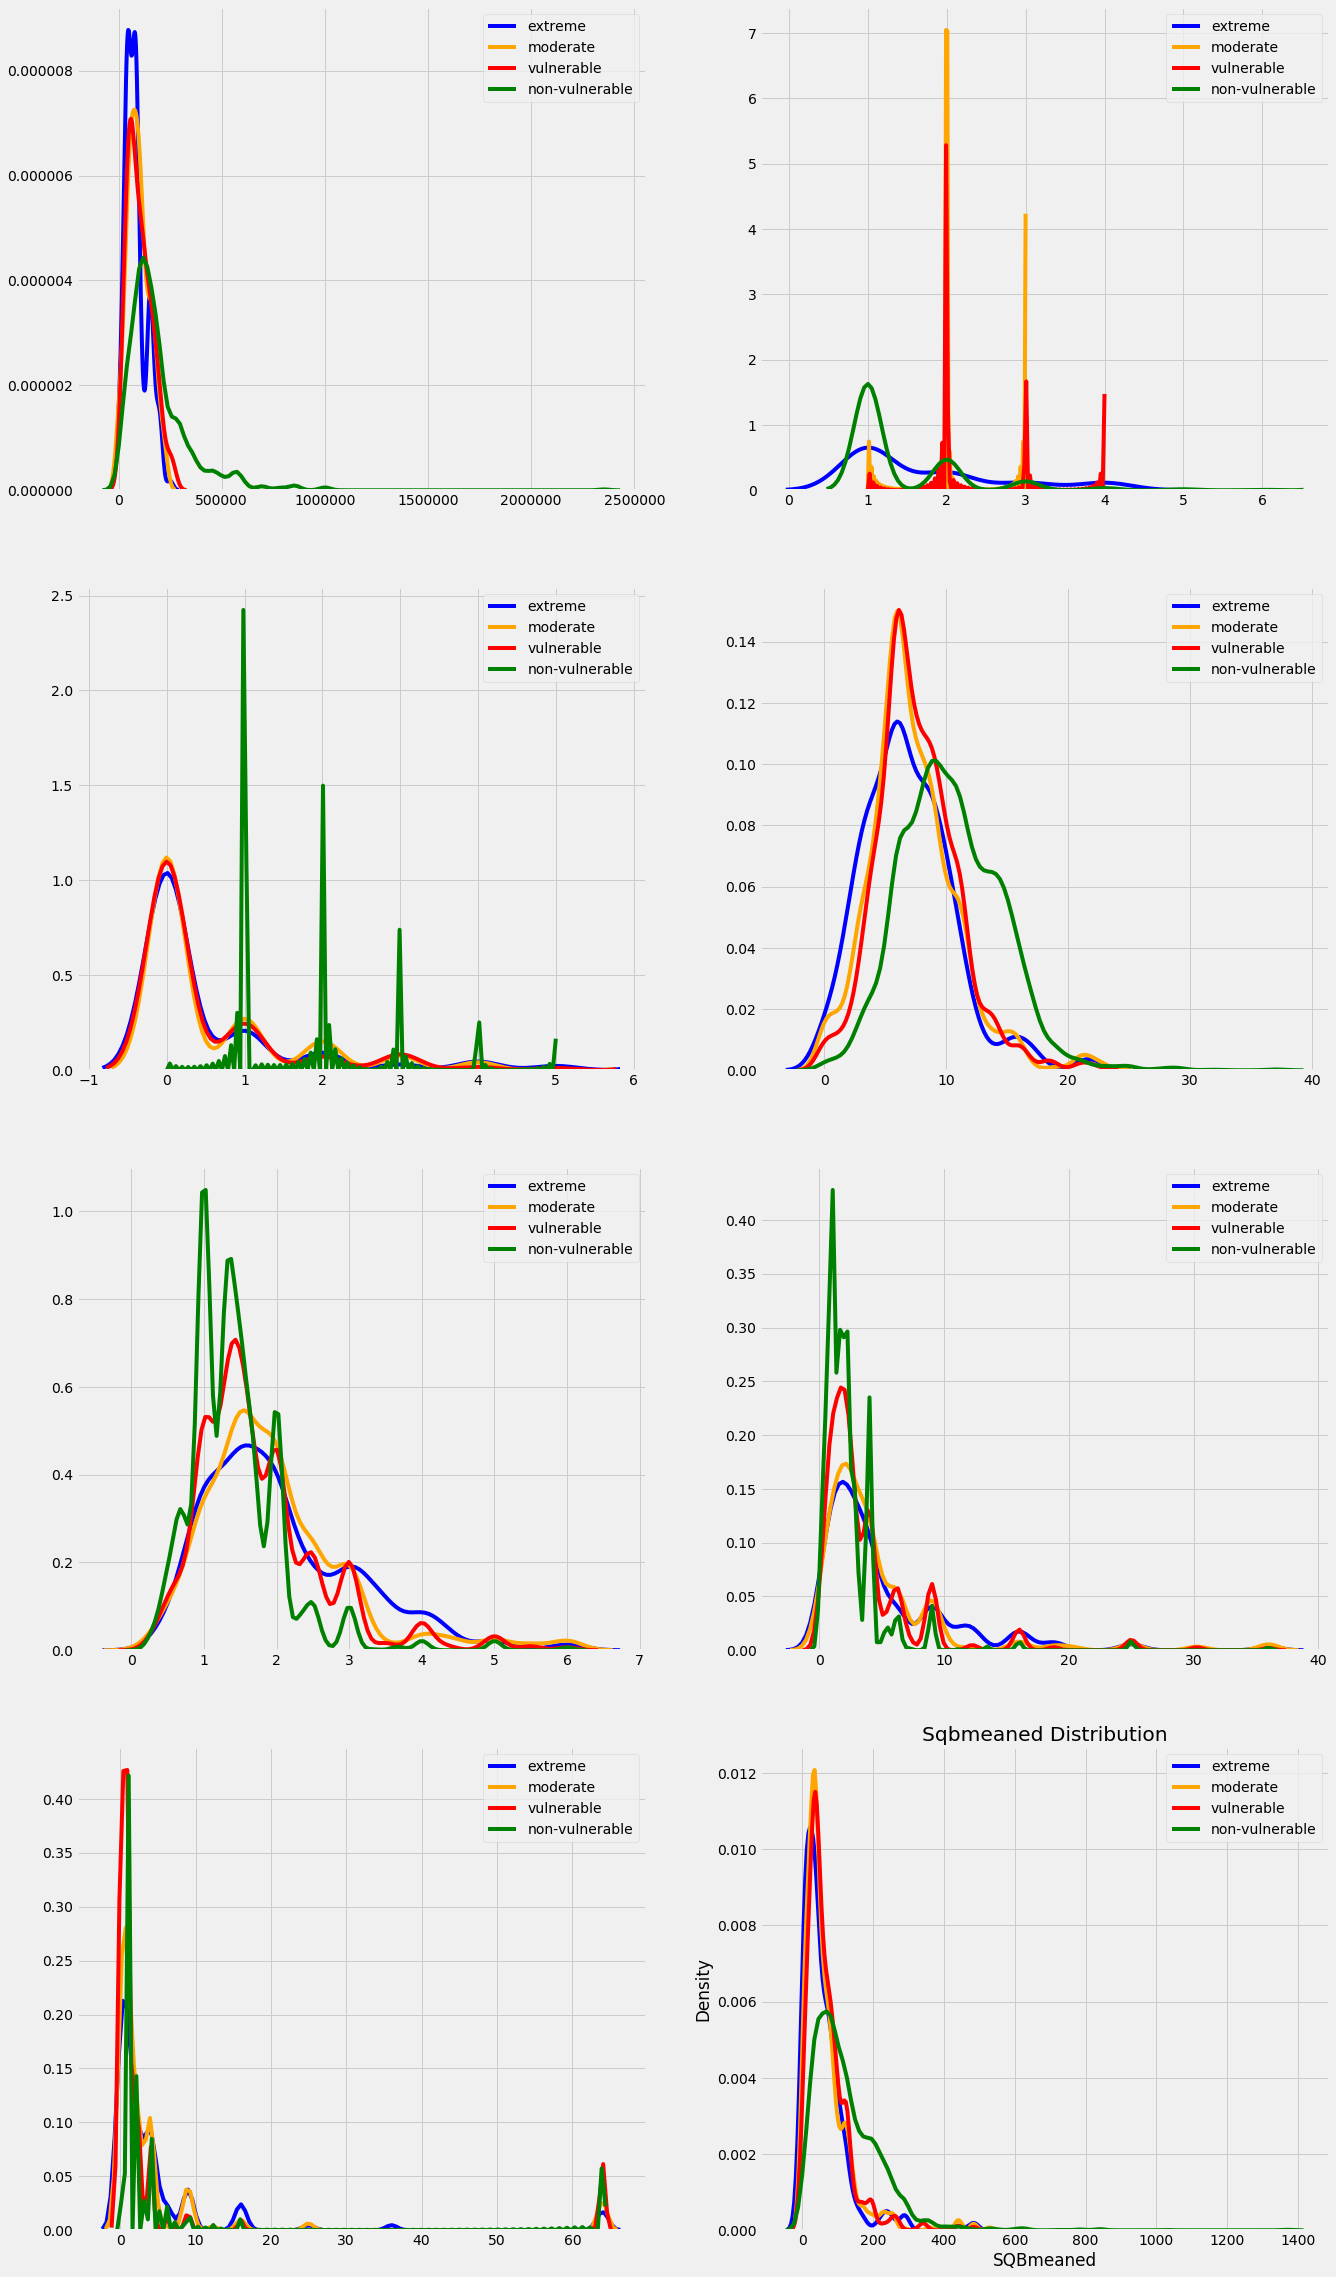

In [35]:
from collections import OrderedDict

plt.figure(figsize = (20, 16))
plt.style.use('fivethirtyeight')

#color mapping
colors = OrderedDict({1: 'blue', 2: 'orange', 3: 'red', 4: 'green'})
poverty_mapping=OrderedDict({1:'extreme', 2:'moderate', 3:'vulnerable', 4:'non-vulnerable'})
# Iterate through the float columns
for i,col in enumerate(train.select_dtypes('float')):
    ax=plt.subplot(4,2,i+1)
# Iterate through the poverty levels
    for poverty_level, color in colors.items():
         # Plot each poverty level as a separate line
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(), 
                    ax = ax, color = color, label = poverty_mapping[poverty_level])
plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')

plt.subplots_adjust(top = 2)



The meaneduc, representing the average education of the adults in the household appears to be related to the poverty level: a higher average adult education leads to higher values of the target which are less severe levels of poverty.

#### Object Data Type

In [36]:
train.select_dtypes('object').head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


According to the documentation for these columns:

- dependency: Dependency rate, calculated = (number of members of the household younger than 19 or older than 64)/(number of member of household between 19 and 64)
- edjefe: years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0
- edjefa: years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0

These explanations clear up the issue. For these three variables, "yes" = 1 and "no" = 0. We can correct the variables using a mapping and convert to floats.

In [37]:
mapping = {"yes": 1, "no": 0}

# Apply same operation to both train and test
for df in [train, test]:
    # Fill in the values with the correct mapping
    df['dependency'] = df['dependency'].replace(mapping).astype(np.float64)
    df['edjefa'] = df['edjefa'].replace(mapping).astype(np.float64)
    df['edjefe'] = df['edjefe'].replace(mapping).astype(np.float64)

train[['dependency', 'edjefa', 'edjefe']].describe()

,dependency,edjefa,edjefe
count,9557.000000,9557.000000,9557.000000
mean,1.149550,2.896830,5.096788
std,1.605993,4.612056,5.246513
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,0.000000,6.000000
75%,1.333333,6.000000,9.000000
max,8.000000,21.000000,21.000000


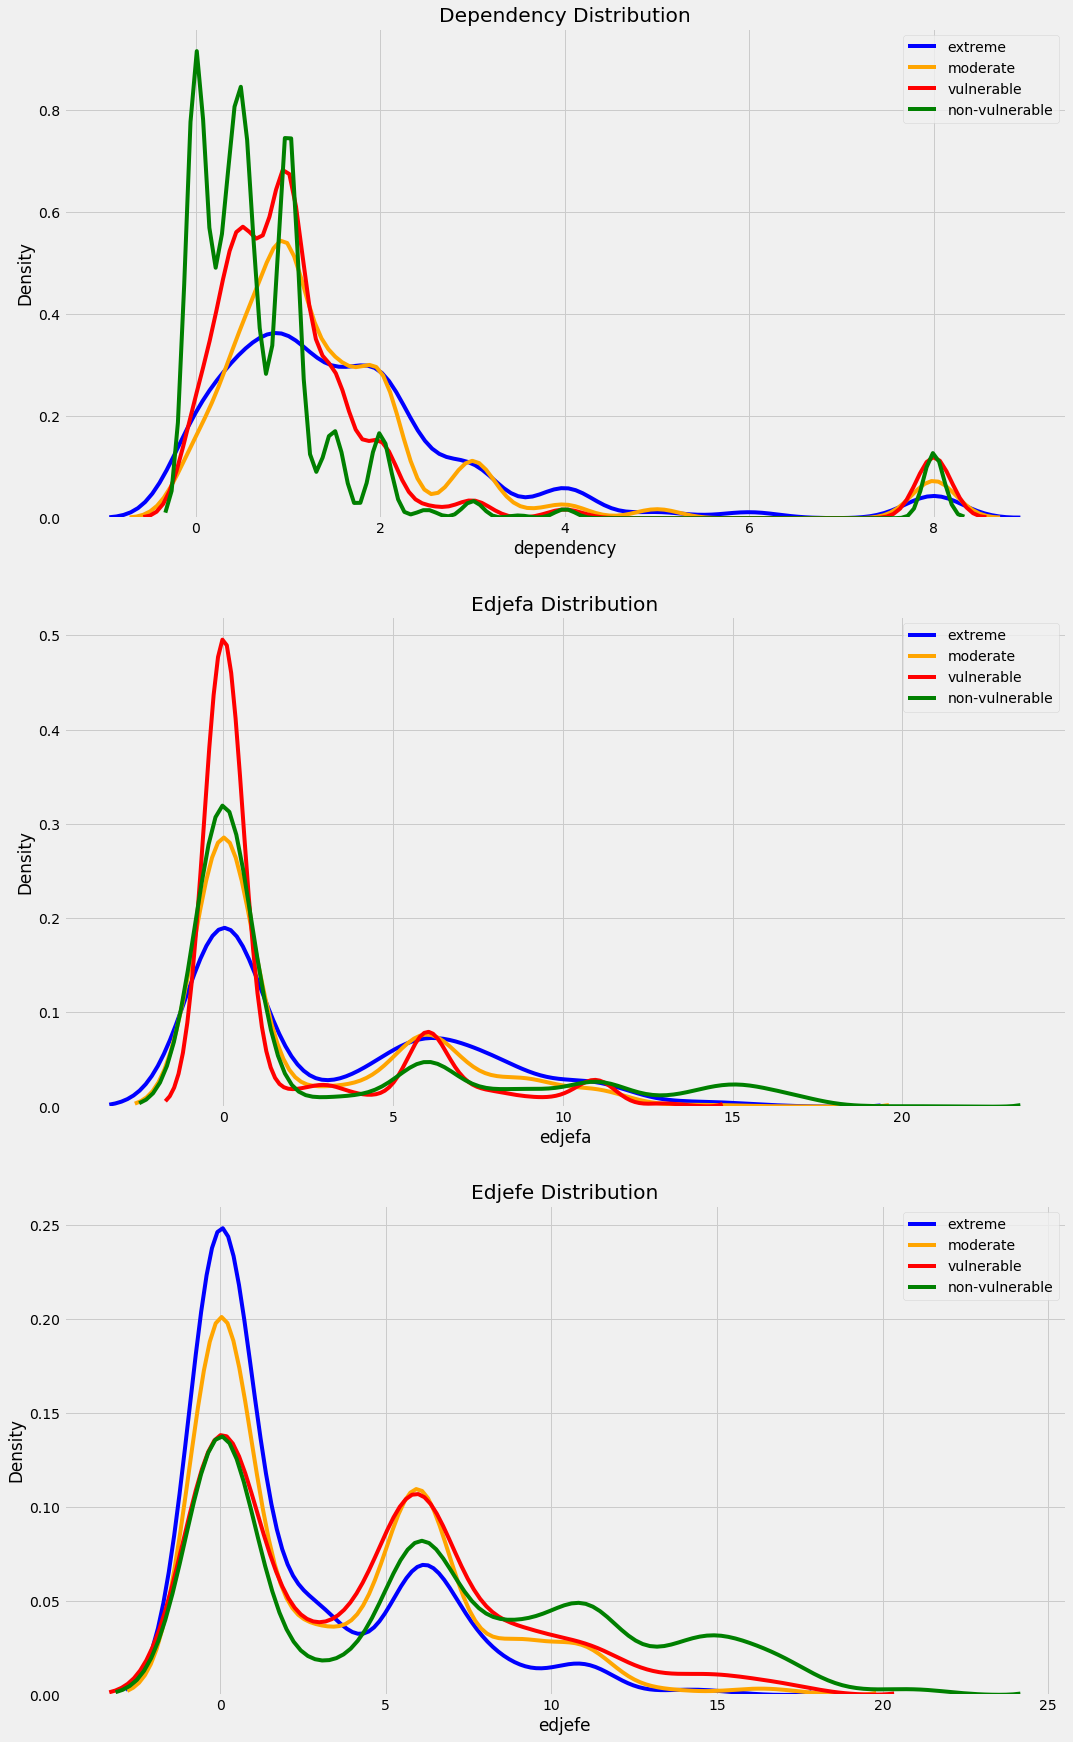

In [38]:
plt.figure(figsize = (16, 12))

# Iterate through the float columns
for i, col in enumerate(['dependency', 'edjefa', 'edjefe']):
    ax = plt.subplot(3, 1, i + 1)
    # Iterate through the poverty levels
    for poverty_level, color in colors.items():
        # Plot each poverty level as a separate line
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(), 
                    ax = ax, color = color, label = poverty_mapping[poverty_level])
        
    plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')

plt.subplots_adjust(top = 2)

These variables are now correctly represented as numbers and can be fed into a machine learning model.

In [39]:
# Add null Target column to test
test['Target'] = np.nan
data = train.append(test, ignore_index = True)

#### Exploring Label Distribution

1.0     222
2.0     442
3.0     355
4.0    1954
Name: Target, dtype: int64

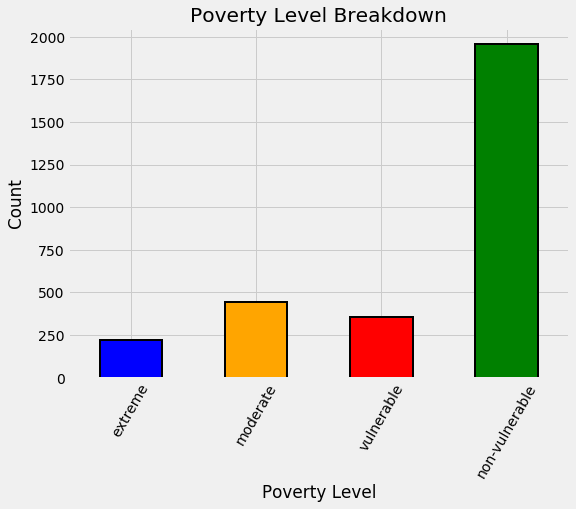

In [43]:
# Heads of household
heads = data.loc[data['parentesco1'] == 1].copy()


# Labels for training
train_labels = data.loc[(data['Target'].notnull()) & (data['parentesco1'] == 1), ['Target', 'idhogar']]

# Value counts of target
label_counts = train_labels['Target'].value_counts().sort_index()

# Bar plot of occurrences of each label
label_counts.plot.bar(figsize = (8, 6), 
                      color = colors.values(),
                      edgecolor = 'k', linewidth = 2)

# Formatting
plt.xlabel('Poverty Level'); plt.ylabel('Count'); 
plt.xticks([x - 1 for x in poverty_mapping.keys()], 
           list(poverty_mapping.values()), rotation = 60)
plt.title('Poverty Level Breakdown');

label_counts

We are dealing with an imbalanced class problem (which makes it intriguing why the contest organizers choose the macro F1 score as the metric instead of weighted F1!). There are many more households that classify as non vulnerable than in any other category. The extreme poverty class is the smallest (I guess this should make us optimistic!)

One problem with imbalanced classification problems is that the machine learning model can have a difficult time predicting the minority classes because itis hard to separate the calsses

#### Errors

To find the households with different labels for family members, we can group the data by the household and then check if there is only one unique value of the Target.

In [44]:
#Groupby the household and figure out the number of unique values
equal=train.groupby('idhogar')['Target'].apply(lambda x:x.nunique()==1)
non_equal=equal[equal!= True]    
print('There are {} households where the family members do not all have the same target.'.format(len(non_equal)))    
    

There are 85 households where the family members do not all have the same target.


In [46]:
train[train['idhogar'] == non_equal.index[0]][['idhogar', 'parentesco1', 'Target']]

,idhogar,parentesco1,Target
7651,0172ab1d9,0,3
7652,0172ab1d9,0,2
7653,0172ab1d9,0,3
7654,0172ab1d9,1,3
7655,0172ab1d9,0,2


For this household, the correct label is 3 for all members.

#### Families without Heads of Household

 "What if there are households without a head of household? And what if the members of those households have differing values of the label?"

In [53]:

leader=train.groupby('idhogar')['parentesco1'].sum()
# Find households without a head
no_leader=train.loc[train['idhogar'].isin(leader[leader==0].index), :]
print('There are {} households without a head.'.format(no_leader['idhogar'].nunique()))


There are 15 households without a head.


In [54]:
# Find households without a head and where labels are different
households_no_head_equal = no_leader.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)
print('{} Households with no head have different labels.'.format(sum(households_no_head_equal == False)))

0 Households with no head have different labels.


If a household does not have a head, then there is no true label. Therefore, we actually won't use any of the households without a head for training. 